In [1]:
# Import the necessary libraries
import pandas as pd
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam # --> Optimierungsalgorithmus
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout

# Define the file paths
subdirectory = "pickle_data_Kuchen"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
#test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(test_features.head())

2025-01-03 00:06:03.886234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 00:06:03.899137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735859163.912103  512531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735859163.916282  512531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 00:06:03.930550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loaded Training features dimensions: (1462, 19)
Loaded Validation features dimensions: (357, 19)
Loaded Test features dimensions: (355, 19)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
      Temp_Cold  Temp_Mild  Temp_Warm  Temp_Hot  KielerWoche  Montag  \
5795          0          1          0         0            0       1   
5796          0          1          0         0            0       0   
5797          0          0          1         0            0       0   
5798          0          1          0         0            0       0   
5799          0          1          0         0            0       0   

      Dienstag  Mittwoch  Donnerstag  Freitag  Samstag  Sonntag    VPI  \
5795         0         0           0        0        0        0  0.052   
5796         1         0           0        0        0        0  0.052   
5797         0         1           0        0        0        0  0.0

In [2]:
def build_model(hp):
    model = keras.Sequential()
    model.add(InputLayer(shape=(training_features.shape[1],)))
    
    # Tune number of layers
    for i in range(hp.Int('num_layers', 1, 4)):
        # Tune number of units in each layer
        units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        model.add(Dense(units=units, activation='relu'))
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', 0, 0.2, step=0.1)
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Output layer
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mape']
    )
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    overwrite=True,
    hyperband_iterations=2,
    directory='keras_tuner',
    project_name='sales_prediction'
)

#checkpoint Callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_checkpoints.weights.h5', save_weights_only=True)

#early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# TensorBoard Callback
root_logdir = Path(tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

# Search for best hyperparameters
tuner.search(
    training_features, 
    training_labels,
    validation_data=(validation_features, validation_labels),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_cb, tensorboard_cb]
)


Trial 60 Complete [00h 00m 14s]
val_loss: 3214.5546875

Best val_loss So Far: 3125.6328125
Total elapsed time: 00h 05m 47s


In [3]:
top3_params = tuner.get_best_hyperparameters(num_trials=3)
top3_params[1].values

{'num_layers': 3,
 'units_0': 128,
 'dropout_0': 0.0,
 'learning_rate': 0.00646670219626612,
 'units_1': 96,
 'dropout_1': 0.2,
 'units_2': 112,
 'dropout_2': 0.0,
 'units_3': 80,
 'dropout_3': 0.1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0042'}

In [4]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    training_features,
    training_labels,
    validation_data=(validation_features, validation_labels),
    epochs=90,
    batch_size=32,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


# Print best hyperparameters
print("\nBest hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")


Epoch 1/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 61166.6602 - mape: 77.8972 - val_loss: 11895.4873 - val_mape: 37.0293
Epoch 2/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9909.0244 - mape: 20.5876 - val_loss: 6710.7988 - val_mape: 21.0352
Epoch 3/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6919.3003 - mape: 17.0667 - val_loss: 6589.9287 - val_mape: 22.7376
Epoch 4/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5767.4331 - mape: 15.9983 - val_loss: 5713.6016 - val_mape: 19.5612
Epoch 5/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9222.5107 - mape: 17.2826 - val_loss: 5426.7979 - val_mape: 16.7267
Epoch 6/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4108.4746 - mape: 15.6867 - val_loss: 4919.4536 - val_mape: 17.5192
Epoch 7/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4921.1963 - mape: 17.0137 - val_loss: 5696.3716 - val_mape: 19.5869
Epoch 8/90
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3282.8308 - mape: 15.5921 - val_loss: 4360.3237 - val_map

In [18]:
# Saving the trained Model
best_model.save("python_model_kuchen.h5")

In [5]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = best_model.predict(training_features)
validation_predictions = best_model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAPE on the Training Data: 14.20%
MAPE on the Validation Data: 16.04%


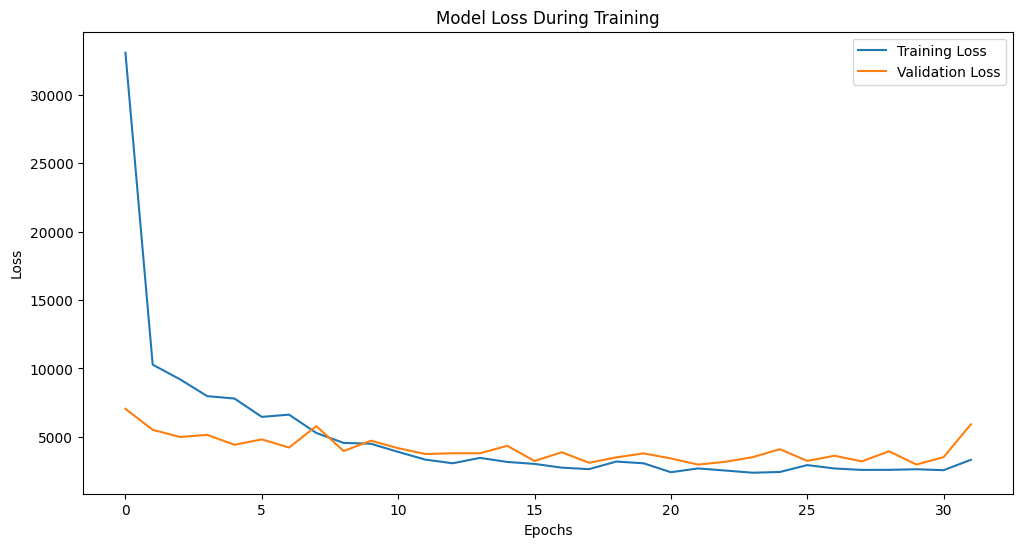

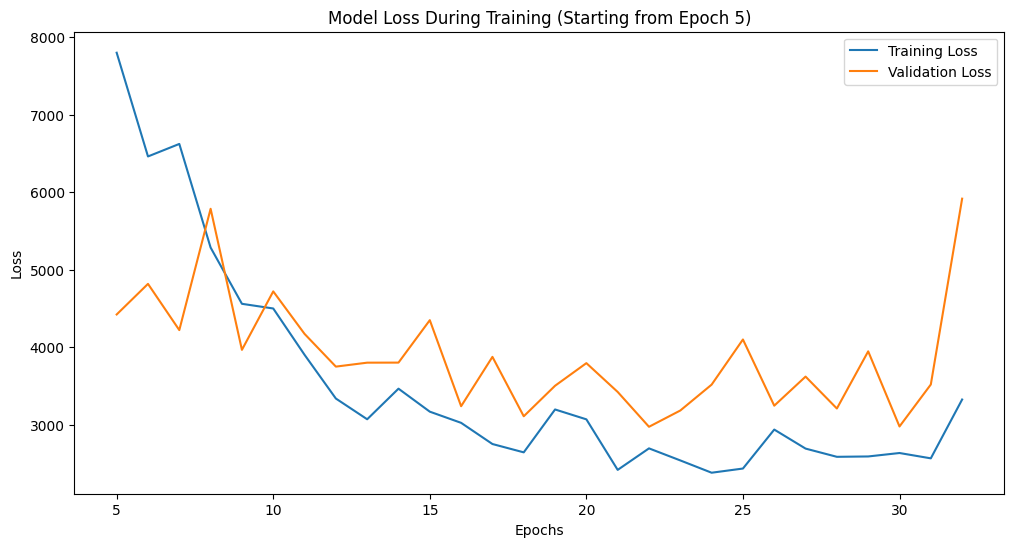

In [38]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(5, len(history.history['loss']) + 1)
training_loss = history.history['loss'][4:]
validation_loss = history.history['val_loss'][4:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


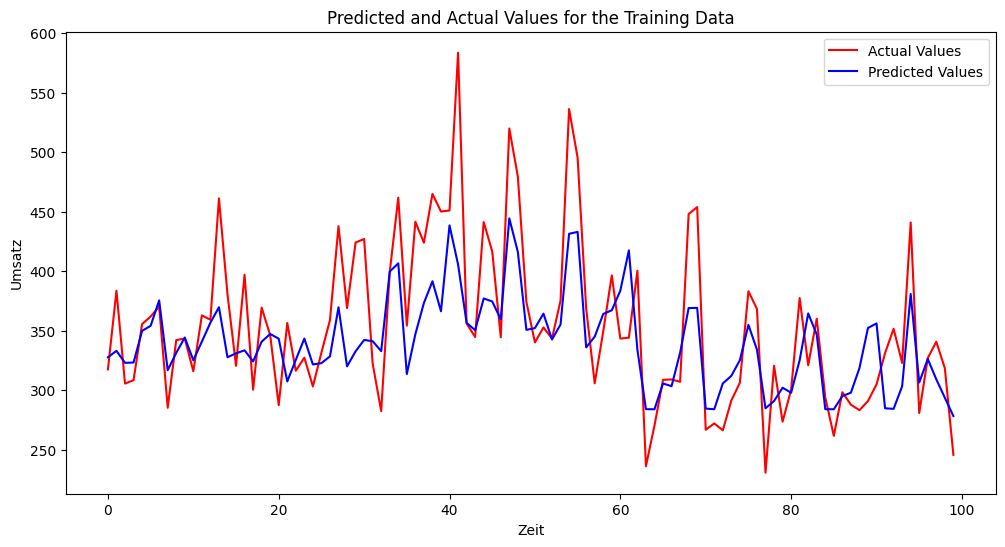

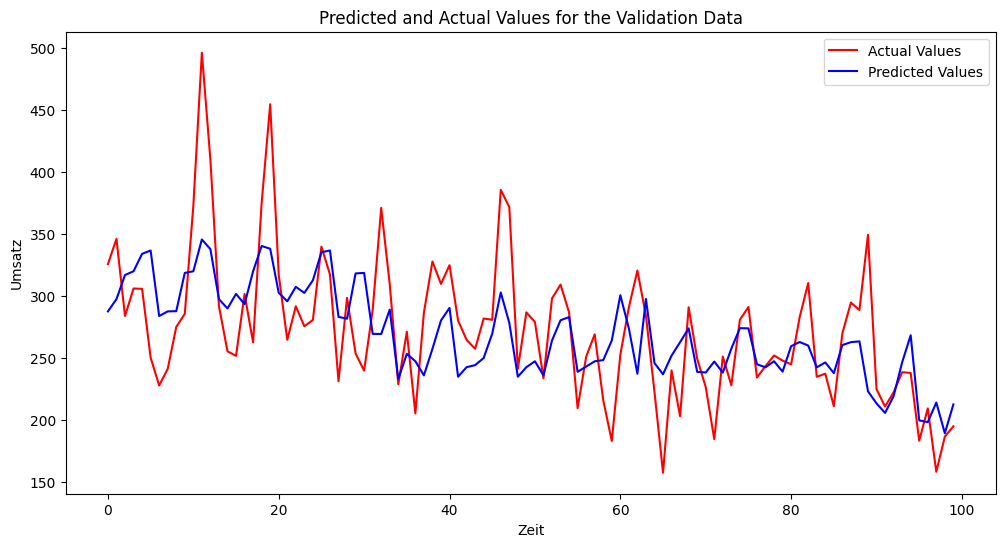

In [39]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

In [8]:
pred = model.predict(test_features)
pred = pd.DataFrame(pred)
pred


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


,0
0,265.161560
1,252.545197
2,267.898193
3,267.210815
4,297.303375
...,...
350,237.470139
351,245.514145
352,261.597839
353,220.628296


In [9]:
test_data = pd.read_csv('../../../0_DataPreparation/00_data/Testdaten.csv')
test_data = test_data[test_data["Warengruppe_5"] == 1]
test_data

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold,Temp_Cold,...,Monat_7,Monat_8,Monat_9,Monat_10,Monat_11,Monat_12,zwischen_den_jahren,Number_of_ships_scaled,Cloud_ok,Wind_ok
1419,1808015,2018-08-01,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1420,1808025,2018-08-02,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1421,1808035,2018-08-03,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,1,1
1422,1808045,2018-08-04,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.2,1,1
1423,1808055,2018-08-05,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,1907265,2019-07-26,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.0,1,1
1770,1907275,2019-07-27,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.6,1,0
1771,1907285,2019-07-28,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.4,1,1
1772,1907295,2019-07-29,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0.2,0,1


In [10]:

# let's merge predictions with the 'id' column:
predictions_df = pd.DataFrame({
    'id': test_data['id'].values,
    'Umsatz': pred[0].values
}).reset_index(drop=True)

predictions_df

,id,Umsatz
0,1808015,265.161560
1,1808025,252.545197
2,1808035,267.898193
3,1808045,267.210815
4,1808055,297.303375
...,...,...
350,1907265,237.470139
351,1907275,245.514145
352,1907285,261.597839
353,1907295,220.628296


In [11]:
# Speichert den DataFrame als CSV-Datei für die Kaggle-Submission
# index=False verhindert, dass eine zusätzliche Indexspalte geschrieben wird
predictions_df.to_csv('02_Kuchen_predictions.csv', index=False)